In [1]:
import os
import pandas as pd
import yaml
import torch
import collections

import warnings

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

warnings.filterwarnings("ignore")

In [7]:
def process_experiment(root_dir):
    rows = []

    for name in os.listdir(root_dir):
        experiment_path = os.path.join(root_dir, name)
        if os.path.isdir(experiment_path):
            for seed_name in os.listdir(experiment_path):
                seed_path = os.path.join(experiment_path, seed_name)
                if os.path.isdir(seed_path):
                    row_data = process_subexperiment(
                        seed_path, os.path.basename(root_dir)
                    )
                    for data in row_data:
                        data["seed"] = seed_name
                        data["experiment_name"] = name
                    rows.extend(row_data)  

    # Create a DataFrame from the rows
    df = pd.DataFrame(rows)
    return df


def process_subexperiment(seed_folder_path, experiment_name):
    cfg_data = read_config(os.path.join(seed_folder_path, "cfg.yaml"), experiment_name)
    train_stats_file = find_train_stats_file(seed_folder_path)
    if train_stats_file:
        experiment_results = process_training_stats(
            train_stats_file, cfg_data
        )
        return experiment_results
    else:
        return []  # Return an empty list if no train stats file is found


def read_config(cfg_path, experiment_name):
    with open(cfg_path, "r") as file:
        config = yaml.safe_load(file)
        full_title = config.get("full_title", "")
        variable_part = remove_experiment_name(full_title, experiment_name)
        return parse_config_variables(variable_part)


def remove_experiment_name(full_title, experiment_name):
    to_remove = experiment_name + "_"
    return (
        full_title[len(to_remove) :].strip()
        if full_title.startswith(to_remove)
        else full_title
    )


def parse_config_variables(variable_str):
    variables = {}
    for part in variable_str.split(";"):
        if "=" in part:
            key, value = part.split("=", 1)
            variables[key.strip()] = value.strip()
    return variables


def find_train_stats_file(folder_path):
    for file in os.listdir(folder_path):
        if file.endswith("_train_stats"):
            return os.path.join(folder_path, file)
    return None


def process_training_stats(train_stats_file, cfg_data):
    checkpoint = torch.load(train_stats_file)

    training_stats = checkpoint.get("training_stats", [])
    validation_stats = checkpoint.get("validation_stats", [])
    redo_stats = checkpoint.get("redo_scores", [])

    stats_records = process_stats(training_stats, cfg_data, "training") + process_stats(
        validation_stats, cfg_data, "validation"
    )

    # Combine stats records with redo scores
    combined_records = []
    for record in stats_records:
        combined_record = record.copy()  # Copy the stats record
        combined_record.update({"redo_score": redo_stats["policy"]})  # Add the redo score
        combined_records.append(combined_record)

    return combined_records


def process_stats(stats, cfg_data, stats_type):
    records = []
    for epoch_stats in stats:
        record = {"epoch_type": stats_type}
        record.update(flatten(epoch_stats))  # Flatten the epoch_stats if it's nested
        record.update(cfg_data)  # Add configuration data
        records.append(record)
    return records


def flatten(d, parent_key="", sep="_"):
    items = []
    for k, v in d.items():
        new_key = parent_key + sep + k if parent_key else k
        if isinstance(v, collections.abc.MutableMapping):
            items.extend(flatten(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [14]:
df = process_experiment(
    r"D:\Work\repos\RL\minatar_work\experiments\training\training_with_redo\results\2023Dec12-012622_configs"
)
df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_frames_min', 'episode_frames_max',
       'episode_frames_mean', 'episode_frames_median', 'episode_frames_std',
       'episode_losses_min', 'episode_losses_max', 'episode_losses_mean',
       'episode_losses_median', 'episode_losses_std', 'episode_max_qs_min',
       'episode_max_qs_max', 'episode_max_qs_mean', 'episode_max_qs_median',
       'episode_max_qs_std', 'policy_trained_times', 'target_trained_times',
       'epoch_time', 'redo.enabled', 'redo.tau', 'environment', 'redo_score',
       'seed', 'experiment_name'],
      dtype='object')

In [15]:
df["experiment_name"].unique()

array(['0000_redo.enabled_True__redo.tau_0.01__environment_breakout',
       '0001_redo.enabled_True__redo.tau_0.05__environment_breakout',
       '0002_redo.enabled_False__redo.tau_0.01__environment_breakout'],
      dtype=object)

In [16]:
mapping_dict = {
    '0000_redo.enabled_True__redo.tau_0.01__environment_breakout': 'tau=0.01',
    '0001_redo.enabled_True__redo.tau_0.05__environment_breakout': 'tau=0.05',
    '0002_redo.enabled_False__redo.tau_0.01__environment_breakout': 'redo=disabled'
}

# Replace values in the DataFrame
df['experiment_name'] = df['experiment_name'].map(mapping_dict)
df["experiment_name"].unique()


array(['tau=0.01', 'tau=0.05', 'redo=disabled'], dtype=object)

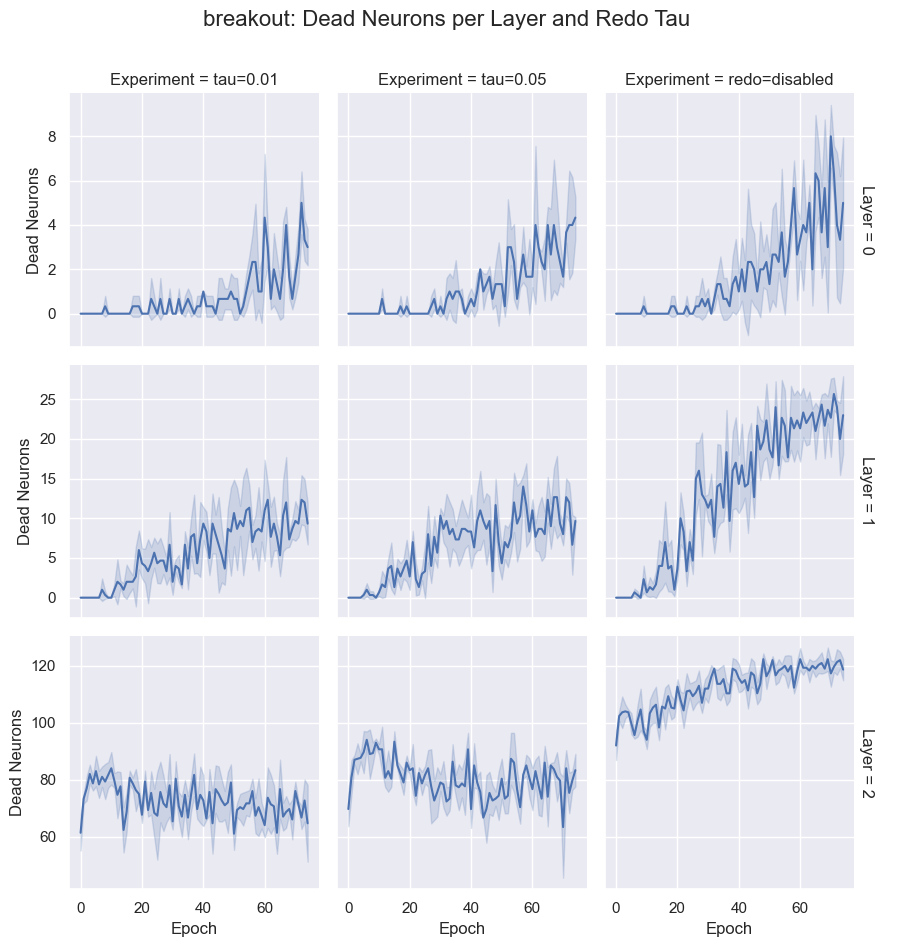

In [17]:
# Assuming 'df' is your DataFrame
# Apply your filters here to create a sub-DataFrame if needed
# Example: sub_df = df[df['some_column'] == some_value]
environment = "breakout"
sub_df = df[df["environment"]==environment]

# Preprocessing to create a long-format DataFrame
long_format_data = []

for index, row in sub_df.iterrows():
    tau = row['redo.tau']
    seed = row['seed']
    scores = row['redo_score']
    experiment = row['experiment_name']

    for epoch_index, epoch_scores in enumerate(scores):
        for layer_index, layer_scores in enumerate(epoch_scores):
            dead_neurons = torch.sum(torch.tensor(layer_scores) <= (float(tau) / len(layer_scores))).item()
            long_format_data.append({
                'Epoch': epoch_index,
                'Layer': layer_index,
                'Redo Tau': tau,
                'Dead Neurons': dead_neurons,
                'Seed': seed,
                'Experiment': experiment
            })
    

long_df = pd.DataFrame(long_format_data)

# Plotting using FacetGrid
g = sns.FacetGrid(long_df, col="Experiment", row="Layer", margin_titles=True, sharey="row")
g.map(sns.lineplot, 'Epoch', 'Dead Neurons', ci='sd')
g.fig.suptitle(f'{environment}: Dead Neurons per Layer and Redo Tau', fontsize=16, y=1.05)
g.add_legend()

plt.show()

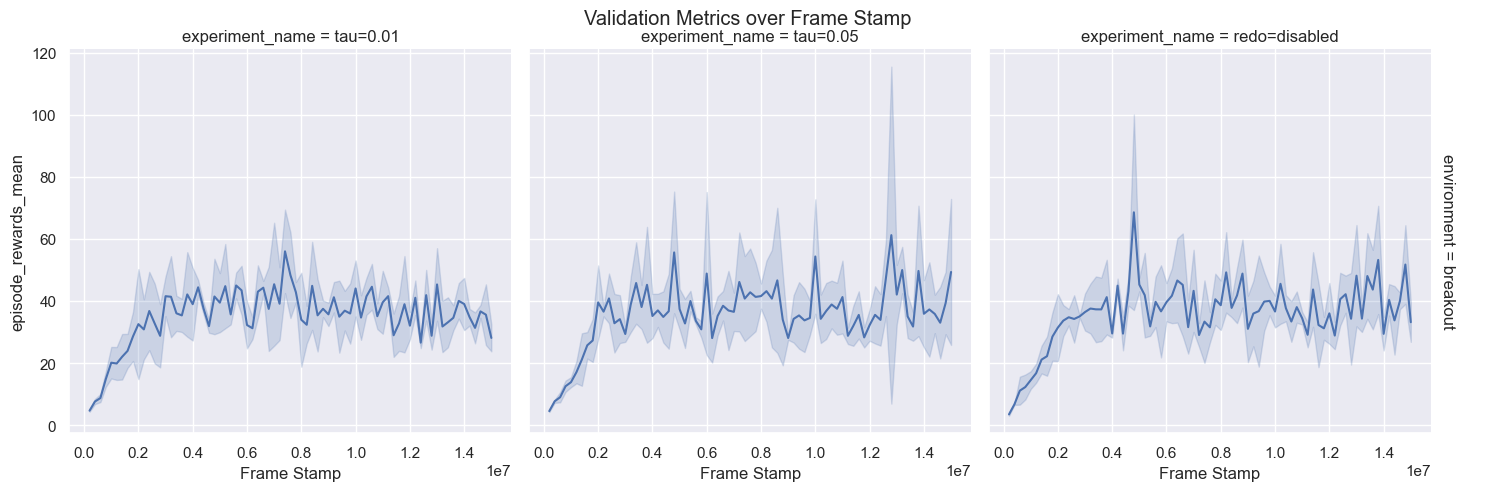

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

# Assuming 'df' is your DataFrame
# Filter for rows where epoch_type is 'validation'
validation_df = df[df["epoch_type"] == "validation"]

# Define your selected_metric and selected_var
selected_metric = "episode_rewards_mean"
selected_var = "experiment_name"

# Create the FacetGrid
g = sns.FacetGrid(
    validation_df, row="environment", col=selected_var, margin_titles=True, height=5
)
g.map(sns.lineplot, "frame_stamp", selected_metric, ci="sd")

# Optional: Adjust the plot's aesthetics
g.set_axis_labels("Frame Stamp", selected_metric)
g.add_legend()
plt.subplots_adjust(top=0.9)
g.fig.suptitle("Validation Metrics over Frame Stamp")

# Show the plot
plt.show()

In [136]:
df.columns

Index(['epoch_type', 'frame_stamp', 'episode_rewards_min',
       'episode_rewards_max', 'episode_rewards_mean', 'episode_rewards_median',
       'episode_rewards_std', 'episode_frames_min', 'episode_frames_max',
       'episode_frames_mean', 'episode_frames_median', 'episode_frames_std',
       'episode_losses_min', 'episode_losses_max', 'episode_losses_mean',
       'episode_losses_median', 'episode_losses_std', 'episode_max_qs_min',
       'episode_max_qs_max', 'episode_max_qs_mean', 'episode_max_qs_median',
       'episode_max_qs_std', 'policy_trained_times', 'target_trained_times',
       'epoch_time', 'redo.tau', 'environment', 'redo_score', 'seed'],
      dtype='object')

Plotting for environment: breakout


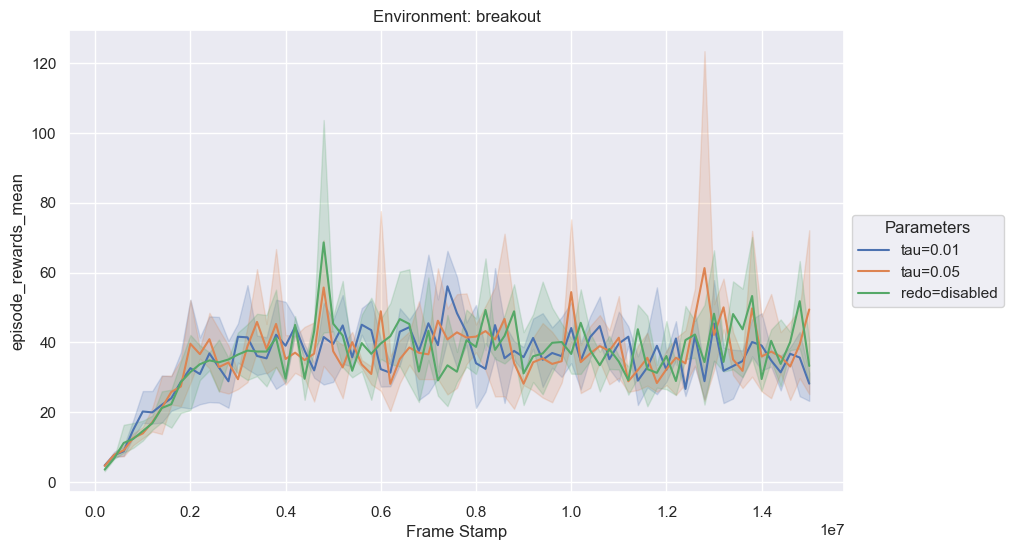

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_metric = "episode_rewards_mean"

validation_df = df[df["epoch_type"] == "validation"]

# Extract unique environments
environments = validation_df["environment"].unique()

for env in environments:
    env_df = validation_df[validation_df["environment"] == env]
  
    print(f"Plotting for environment: {env}")
 
    # Create a new figure for each environment
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=env_df, x="frame_stamp", y=selected_metric, hue="experiment_name")
    plt.title(f"Environment: {env}")
    plt.ylabel(selected_metric)
    plt.xlabel("Frame Stamp")

    # Place the legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Parameters")
    plt.show()

Plotting for environment: breakout
redo.tau


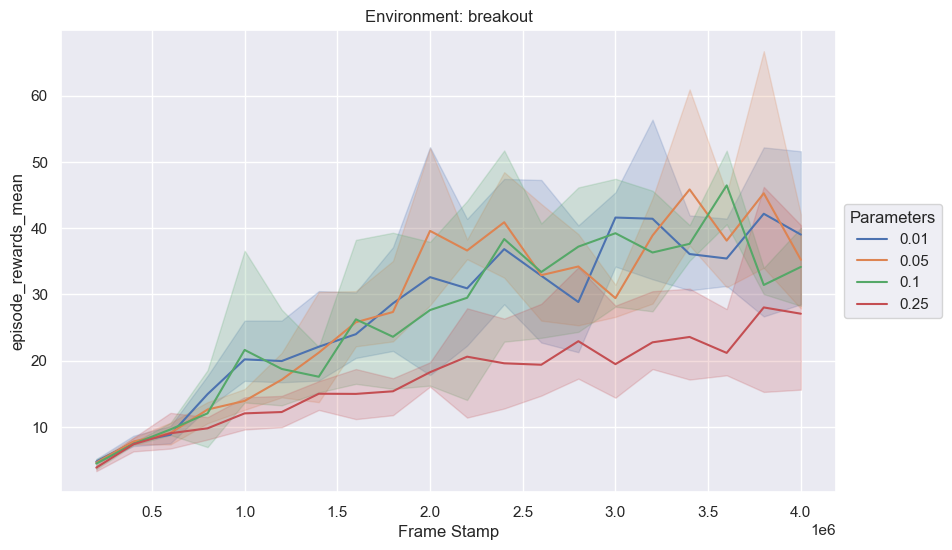

Plotting for environment: asterix
redo.tau


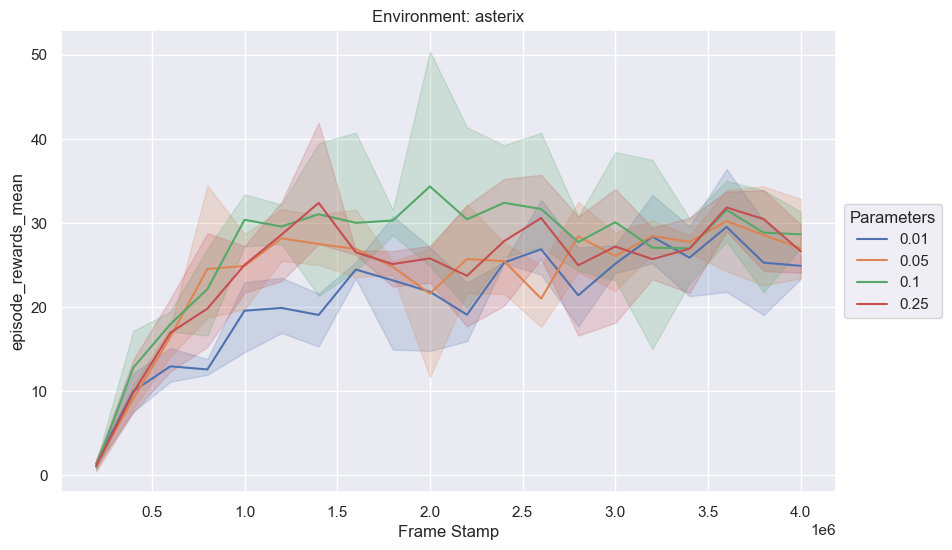

In [137]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_metric = "episode_rewards_mean"

validation_df = df[df["epoch_type"] == "validation"]

# Extract unique environments
environments = validation_df["environment"].unique()

for env in environments:
    env_df = validation_df[validation_df["environment"] == env]
    env_df["parameters"] = env_df[["redo.tau"]].apply(
        lambda x: "_".join(x.astype(str)), axis=1
    )

    print(f"Plotting for environment: {env}")
    print("redo.tau")

    # Create a new figure for each environment
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=env_df, x="frame_stamp", y=selected_metric, hue="parameters")
    plt.title(f"Environment: {env}")
    plt.ylabel(selected_metric)
    plt.xlabel("Frame Stamp")

    # Place the legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Parameters")
    plt.show()

In [138]:
import seaborn as sns
import matplotlib.pyplot as plt

selected_metric = "episode_rewards_mean"

validation_df = df[df["epoch_type"] == "validation"]

# Extract unique environments
environments = validation_df["environment"].unique()

for env in environments:
    env_df = validation_df[validation_df["environment"] == env]
    env_df["parameters"] = env_df[
        ["agent_params.args_.target_model_update_freq"]
    ].apply(lambda x: "_".join(x.astype(str)), axis=1)

    print(f"Plotting for environment: {env}")
    print("redo.redo_freq", "redo.tau", "agent_params.args_.target_model_update_freq")

    # Create a new figure for each environment
    plt.figure(figsize=(10, 6))
    sns.lineplot(data=env_df, x="frame_stamp", y=selected_metric, hue="parameters")
    plt.title(f"Environment: {env}")
    plt.ylabel(selected_metric)
    plt.xlabel("Frame Stamp")

    # Place the legend outside the plot
    plt.legend(loc="center left", bbox_to_anchor=(1.0, 0.5), title="Parameters")
    plt.show()

KeyError: "None of [Index(['agent_params.args_.target_model_update_freq'], dtype='object')] are in the [columns]"

In [ ]:
import os, sys


def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("."), 3)
sys.path.append(proj_root)

import yaml
import itertools
from pathlib import Path
import datetime
import multiprocessing
import traceback
from typing import List, Dict, Tuple

from liftoff import parse_opts


from minatar_dqn.utils import my_logging
from minatar_dqn import my_dqn
from experiments.experiment_utils import seed_everything
from experiments.training.training import create_path_to_experiment_folder

In [ ]:
def convert_namespace_to_dict(obj):
    if isinstance(obj, dict):
        return {k: convert_namespace_to_dict(v) for k, v in obj.items()}
    elif hasattr(obj, "__dict__"):
        return {k: convert_namespace_to_dict(v) for k, v in obj.__dict__.items()}
    else:
        return obj

In [ ]:
with open(
    r"D:\Work\repos\RL\minatar_work\experiments\training\training_with_redo\results\2023Nov24-190816_configs\0000_redo.redo_freq_500__redo.tau_0.01__agent_params.args_.target_model_update_freq_100__environment_breakout\0\cfg.yaml",
    "r",
) as file:
    config = yaml.safe_load(file)
config = convert_namespace_to_dict(config)
config

{'agent_params': {'agent': 'AgentDQN',
  'args_': {'batch_size': 32,
   'epsilon': {'decay': 250000, 'end': 0.01, 'start': 1.0},
   'gamma': 0.99,
   'loss_fcn': 'mse_loss',
   'replay_start_size': 5000,
   'target_model_update_freq': 100,
   'train_step_cnt': 200000,
   'training_freq': 4,
   'validation_enabled': True,
   'validation_epsilon': 0.001,
   'validation_step_cnt': 125000}},
 'cfg_id': 0,
 'environment': 'breakout',
 'epochs_to_train': 20,
 'estimator': {'args_': {'conv_hidden_out_size': 32,
   'lin_hidden_out_size': 128},
  'model': 'Conv_QNET'},
 'experiment': 'redo_experiment',
 'experiment_arguments': {'agent_params': {'args_': {'target_model_update_freq': 100}},
  'environment': 'breakout',
  'redo': {'redo_freq': 500, 'tau': 0.01}},
 'full_title': '2023Nov24-190816_configs_redo.redo_freq=500; redo.tau=0.01; agent_params.args_.target_model_update_freq=100; environment=breakout',
 'optim': {'args_': {'eps': 0.00015, 'lr': 6.25e-05}, 'name': 'Adam'},
 'out_dir': '.\\res

In [ ]:
config["estimator"]

{'args_': {'conv_hidden_out_size': 32, 'lin_hidden_out_size': 128},
 'model': 'Conv_QNET'}

In [ ]:
# config = convert_namespace_to_dict(opts)

seed = int(os.path.basename(config["out_dir"]))

seed_everything(seed)

logs_file = os.path.join(config["out_dir"], "experiment_log.log")

logger = my_logging.setup_logger(
    name=config["experiment"],
    log_file=logs_file,
)

logger.info(f"Starting experiment: {config['full_title']}")

### Setup environments ###
train_env = my_dqn.build_environment(game_name=config["environment"], random_seed=seed)
validation_env = my_dqn.build_environment(
    game_name=config["environment"], random_seed=seed
)

### Setup output and loading paths ###

path_previous_experiments_outputs = None
if "restart_training_timestamp" in config:
    path_previous_experiments_outputs = create_path_to_experiment_folder(
        config,
        config["out_dir"],
        config["restart_training_timestamp"],
    )

experiment_agent = my_dqn.AgentDQN(
    train_env=train_env,
    validation_env=validation_env,
    experiment_output_folder=config["out_dir"],
    experiment_name=config["experiment"],
    resume_training_path=path_previous_experiments_outputs,
    save_checkpoints=True,
    logger=logger,
    config=config,
    enable_tensorboard_logging=False,
)

2023-11-26 02:27:19,288 - redo_experiment - INFO - Starting experiment: 2023Nov24-190816_configs_redo.redo_freq=500; redo.tau=0.01; agent_params.args_.target_model_update_freq=100; environment=breakout
2023-11-26 02:27:19,293 - redo_experiment - INFO - Loaded configuration settings.
2023-11-26 02:27:19,300 - redo_experiment - INFO - Initialized newtworks and optimizer.
2023-11-26 02:27:19,301 - redo_experiment - INFO - Applied redo parametrization to policy model.
2023-11-26 02:27:19,302 - redo_experiment - INFO - Applied redo parametrization to target model.


c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\envs\registration.py:555: UserWarning: WARN: The environment MinAtar/Breakout-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:20: UserWarning: WARN: It seems a Box observation space is an image but the `dtype` is not `np.uint8`, actual type: bool. If the Box observation space is not an image, we recommend flattening the observation to have only a 1D vector.
  logger.warn(
c:\Users\Chainsword\anaconda3\envs\general\lib\site-packages\gym\utils\passive_env_checker.py:25: UserWarning: WARN: It seems a Box observation space is an image but the upper and lower bounds are not in [0, 255]. Generally, CNN policies assume observations are within that range, so you may encounter an issue if the observation values are not.
  logger.warn(


In [ ]:
experiment_agent.policy_model

Conv_QNET(
  (features): Sequential(
    (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
  )
  (fc): Sequential(
    (lin1): Linear(in_features=1152, out_features=128, bias=True)
    (relu3): ReLU()
    (lin2): Linear(in_features=128, out_features=6, bias=True)
  )
)

In [ ]:
import torch

checkpoint = torch.load(
    r"D:\Work\repos\RL\minatar_work\experiments\training\training_with_redo\results\2023Nov24-190816_configs\0000_redo.redo_freq_500__redo.tau_0.01__agent_params.args_.target_model_update_freq_100__environment_breakout\0\model_checkpoints\mck_20"
)
experiment_agent.policy_model.load_state_dict(checkpoint["policy_model_state_dict"])

<All keys matched successfully>

In [ ]:
experiment_agent.policy_model

Conv_QNET(
  (features): Sequential(
    (conv1): Conv2d(4, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu1): ReLU()
    (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (relu2): ReLU()
  )
  (fc): Sequential(
    (lin1): Linear(in_features=1152, out_features=128, bias=True)
    (relu3): ReLU()
    (lin2): Linear(in_features=128, out_features=6, bias=True)
  )
)
